# Organize the code in Pytorch way

In [10]:
import random
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
# retina display
%config InlineBackend.figure_format = 'retina'

In [3]:
# write up your own neural network
class Linear: 

    def __init__(self, fan_in, fan_out, g, bias=True):
        self.weight = torch.randn(fan_in, fan_out, generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight, self.bias] if self.bias is not None else [self.weight]

In [153]:
# batchnorm1d
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # gamma and beta are learnable parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # ema_mean and ema_var are not learnable
        self.ema_mean = torch.zeros(dim)
        self.ema_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            # calculate mean and var
            x_mean = x.mean(dim=0, keepdim=True)
            x_var = x.var(dim=0, keepdim=True)
        else:
            # use ema_mean and ema_var during inference
            x_mean = self.ema_mean
            x_var = self.ema_var
        # normalize the input
        x_hat = (x - x_mean) / (x_var + self.eps) ** 0.5
        self.out = self.gamma * x_hat + self.beta

        # update ema_mean and ema_var
        if self.training:
            with torch.no_grad():
                # weighted average between data mean/var and ema_mean/var
                # where ema_mean/var is the weighted average of previous
                # ema_mean/var and current data mean/var
                # you can think of it as a low pass filter
                self.ema_mean = self.momentum * self.ema_mean + (1 - self.momentum) * x_mean
                self.ema_var = self.momentum * self.ema_var + (1 - self.momentum) * x_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [5]:
# tahn activation
class Tanh:
    
        def __call__(self, x):
            self.out = torch.tanh(x)
            return self.out
        
        def parameters(self):
            return []

In [6]:
# read the dataset
# read the dataset
words = open('./data/names.txt', 'r').read().splitlines()
print('Number of words:', len(words))

Number of words: 32033


In [7]:
# build up the dictionary for mapping characters to integers
chars = sorted(list(set(''.join(words))))
print('Number of characters:', len(chars))
# chars to integers
char2int = {c: i+1 for i, c in enumerate(chars)}
# add . as the padding character
char2int['.'] = 0
# integers to chars
int2char = {i: c for c, i in char2int.items()}
# vocabulary size
vocab_size = len(char2int)

Number of characters: 26


In [8]:
# build the dataset
block_size = 3 

def build_dataset(words):
    X, Y = [], []
    for word in words:
        # add . as the padding character to the beginning of the word
        context = [0] * block_size
        for char in word + '.':
            X.append(context)
            Y.append(char2int[char])
            # update the context
            context = context[1:] + [char2int[char]]
    # convert to tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print('X:', X.shape, 'Y:', Y.shape)
    return X, Y

In [11]:
# split the dataset into training and validation sets
# 80%, 10%, 10%
# set the random seed
random.seed(666)
# shuffle the words
random.shuffle(words)
# split the words
train_words = words[:int(0.8*len(words))]
val_words = words[int(0.8*len(words)):int(0.9*len(words))]
test_words = words[int(0.9*len(words)):]

# build the datasets
X_train, Y_train = build_dataset(train_words)
X_val, Y_val = build_dataset(val_words)
X_test, Y_test = build_dataset(test_words)

X: torch.Size([182426, 3]) Y: torch.Size([182426])
X: torch.Size([22807, 3]) Y: torch.Size([22807])
X: torch.Size([22913, 3]) Y: torch.Size([22913])


In [154]:
# train the model
n_embed = 10
n_hidden = 100 
g_seed = torch.Generator().manual_seed(42)
C_embed = torch.randn(vocab_size, n_embed)
layers = [
    Linear(n_embed*block_size, n_hidden, g_seed), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden, g_seed), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden, g_seed), BatchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden,n_hidden, g_seed), BatchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden,n_hidden, g_seed), BatchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden, vocab_size, g_seed), BatchNorm1d(vocab_size)
]

In [155]:
with torch.no_grad():
    # last layer is less confident, which means the weight is smaller
    layers[-1].gamma *= 0.1
    # for other layers, the weight is larger
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # best practice

# collect all the parameters
params = [C_embed] + [p for layer in layers for p in layer.parameters()]
# print the number of parameters
print('Number of parameters:', sum(p.numel() for p in params))
# set gradient 
for p in params:
    p.requires_grad = True

Number of parameters: 47551


In [156]:
# train the model
max_steps = 200000 
batch_size = 32
loss_history = []
update_ratio_history = []

for i in range(max_steps):
    # get the batch
    batch_idx = torch.randint(0, len(X_train), (batch_size,), generator=g_seed)
    batch_X, batch_Y = X_train[batch_idx], Y_train[batch_idx]

    # forward pass
    embeded = C_embed[batch_X]
    # flatten the input
    out = embeded.view(embeded.shape[0], -1)
    for layer in layers:
        out = layer(out)
    # calculate the loss
    loss = F.cross_entropy(out, batch_Y)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # for debugging
    # clear the previous gradients
    for p in params:
        p.grad = None
    loss.backward()

    # update the parameters
    alpha = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data -= alpha * p.grad

    # print the loss
    loss_history.append(loss.log10().item())
    # append the update ratio
    update_ratio_history.append([(alpha * p.grad.std() / p.data.std()).log10().item() for p in params])
    
    if i % 10000 == 0:
        print(f'Step {i:7d}/{max_steps:7d}, loss {loss.item():.4f}')
    
    if i > 1000:
        break

Step       0/ 200000, loss 3.3069


layer 2 (      Tanh): mean +0.00, std 0.62 saturated: 3.25%
layer 5 (      Tanh): mean -0.01, std 0.63 saturated: 2.81%
layer 8 (      Tanh): mean -0.00, std 0.65 saturated: 2.44%
layer 11 (      Tanh): mean -0.01, std 0.64 saturated: 2.66%
layer 14 (      Tanh): mean +0.01, std 0.65 saturated: 2.44%


Text(0.5, 1.0, 'Histogram of the activations')

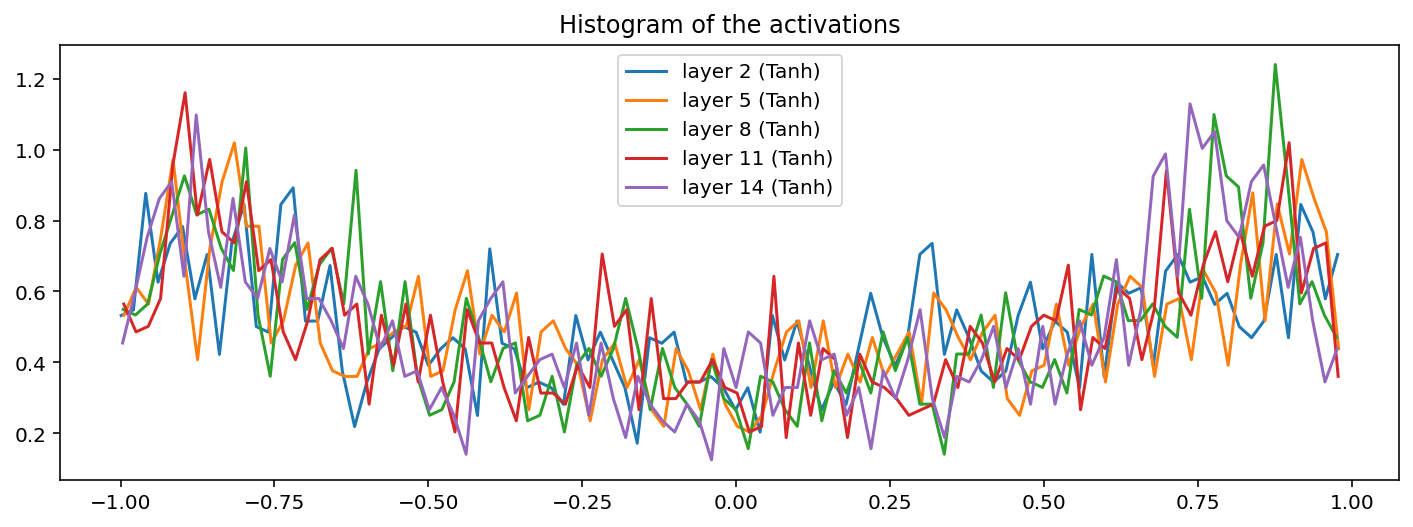

In [157]:
# visualize the neuron activations
plt.figure(figsize=(12, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        # print out the mean and std of the activations and saturated rate
        print("layer %d (%10s): mean %+.2f, std %.2f saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        # plot the histogram of the activations
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Histogram of the activations')

__Remark__: When the weight is small in each layer, then the data will be transformed to a small range. With the `Tanh` activation function, the output will be in a small range.
However, if the weight is large, then the output will be in a large range. With the `Tanh` activation function, the output will be in a large range. This will saturate the `Tanh` activation function. This will cause the gradient to be small. This is called the `vanishing gradient` problem.

layer 2 (      Tanh): mean +0.000000, std 3.15e-03
layer 5 (      Tanh): mean -0.000000, std 2.84e-03
layer 8 (      Tanh): mean -0.000000, std 2.58e-03
layer 11 (      Tanh): mean -0.000000, std 2.48e-03
layer 14 (      Tanh): mean -0.000000, std 2.23e-03


Text(0.5, 1.0, 'Histogram of the gradients')

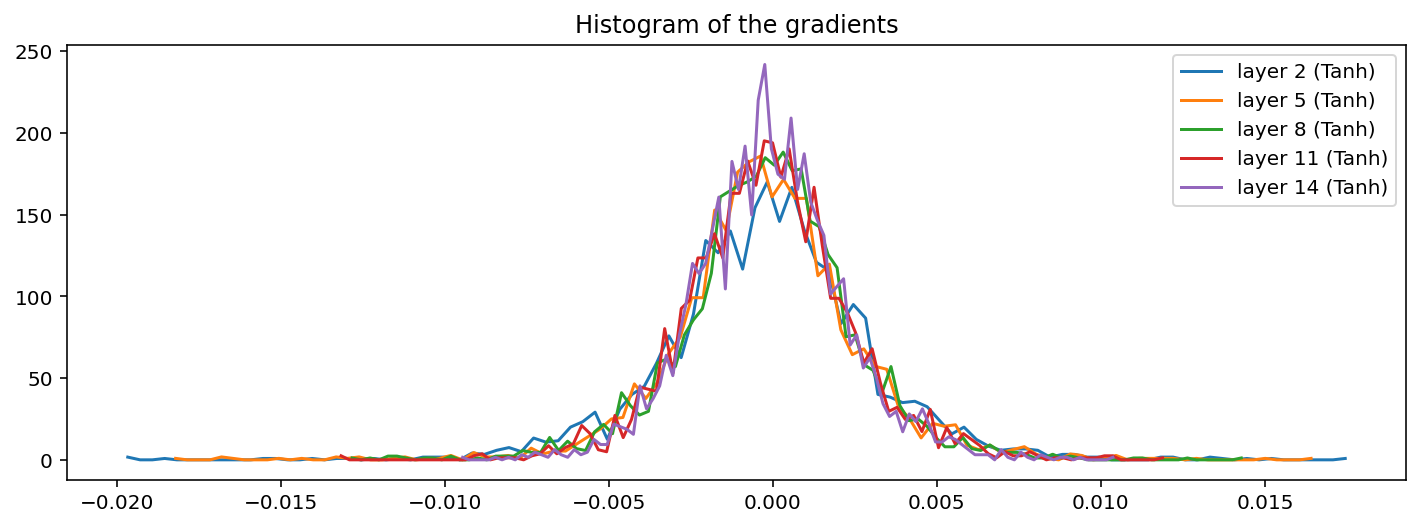

In [158]:
# visualize gradients
plt.figure(figsize=(12, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        tg = layer.out.grad
        # print out the mean and std of the gradients
        print("layer %d (%10s): mean %+f, std %.2e" % (i, layer.__class__.__name__, tg.mean(), tg.std()))
        # plot the histogram of the gradients
        hy, hx = torch.histogram(tg, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Histogram of the gradients')

layer 0 (    Linear): mean -0.10, std 1.68 saturated: 56.81%
layer 3 (    Linear): mean -0.01, std 1.06 saturated: 35.03%
layer 6 (    Linear): mean -0.00, std 1.17 saturated: 42.03%
layer 9 (    Linear): mean -0.00, std 1.21 saturated: 42.91%
layer 12 (    Linear): mean +0.00, std 1.16 saturated: 42.16%
layer 15 (    Linear): mean -0.00, std 1.45 saturated: 48.26%


Text(0.5, 1.0, 'Histogram of the activations')

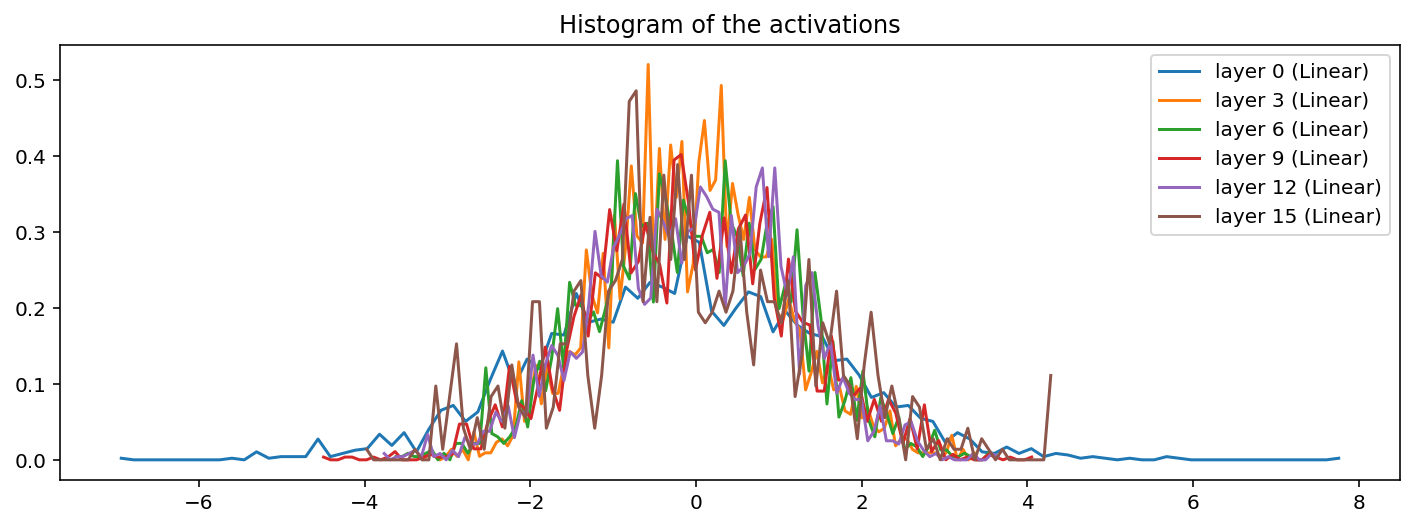

In [159]:
# visualize the neuron activations
plt.figure(figsize=(12, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out
        # print out the mean and std of the activations and saturated rate
        print("layer %d (%10s): mean %+.2f, std %.2f saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        # plot the histogram of the activations
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Histogram of the activations')

layer 0 (    Linear): mean -0.000000, std 1.46e-03
layer 3 (    Linear): mean -0.000000, std 1.87e-03
layer 6 (    Linear): mean -0.000000, std 1.57e-03
layer 9 (    Linear): mean +0.000000, std 1.45e-03
layer 12 (    Linear): mean -0.000000, std 1.36e-03
layer 15 (    Linear): mean -0.000000, std 2.67e-03


Text(0.5, 1.0, 'Histogram of the gradients')

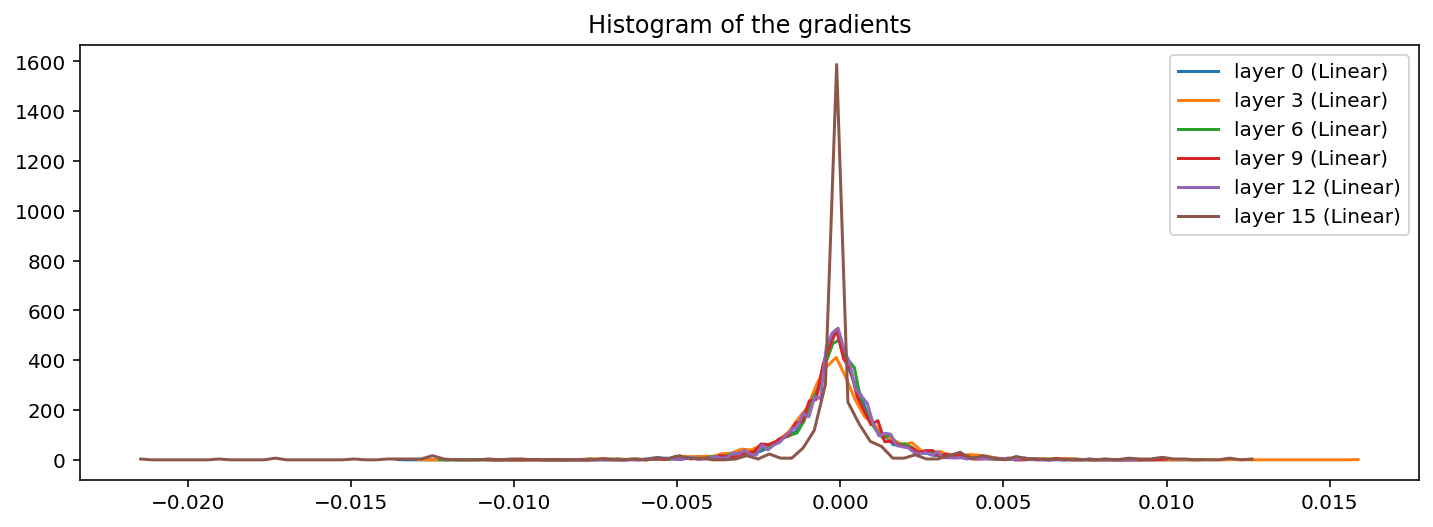

In [160]:
# visualize gradients
plt.figure(figsize=(12, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        tg = layer.out.grad
        # print out the mean and std of the gradients
        print("layer %d (%10s): mean %+f, std %.2e" % (i, layer.__class__.__name__, tg.mean(), tg.std()))
        # plot the histogram of the gradients
        hy, hx = torch.histogram(tg, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Histogram of the gradients')

layer  0 : shape   (27, 10) | mean -0.000000 | std 7.66e-03 | ratio 7.28e-03
layer  1 : shape  (30, 100) | mean -0.000022 | std 7.80e-03 | ratio 2.57e-02
layer  5 : shape (100, 100) | mean -0.000069 | std 6.98e-03 | ratio 4.19e-02
layer  9 : shape (100, 100) | mean -0.000186 | std 6.03e-03 | ratio 3.60e-02
layer 13 : shape (100, 100) | mean -0.000008 | std 5.61e-03 | ratio 3.35e-02
layer 17 : shape (100, 100) | mean -0.000001 | std 5.68e-03 | ratio 3.38e-02
layer 21 : shape  (100, 27) | mean -0.000241 | std 1.16e-02 | ratio 6.96e-02


Text(0.5, 1.0, 'Histogram of the weights')

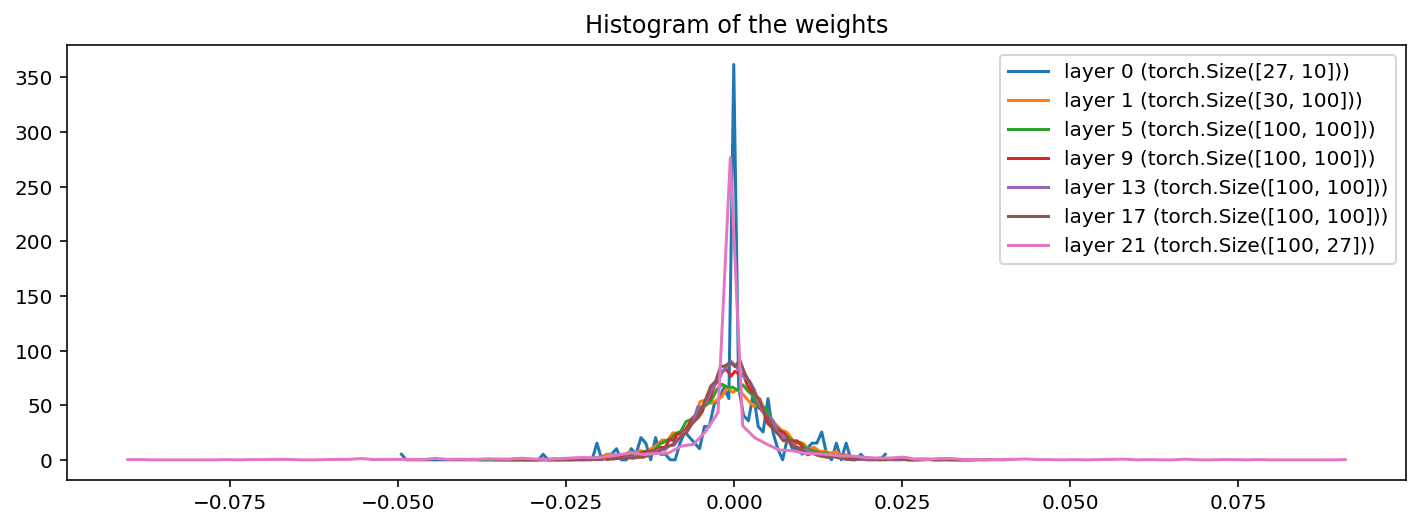

In [161]:
# visualize all weights
plt.figure(figsize=(12, 4))
legends = []
for i, p in enumerate(params):
    t = p.grad
    if p.ndim == 2:
        # print out shapre of the weights, mean, std and gradient/data ratio
        print("layer %2d : shape %10s | mean %+f | std %.2e | ratio %.2e" % (i, tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        # plot the histogram of the gradients
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({p.shape})')
plt.legend(legends)
plt.title('Histogram of the weights')

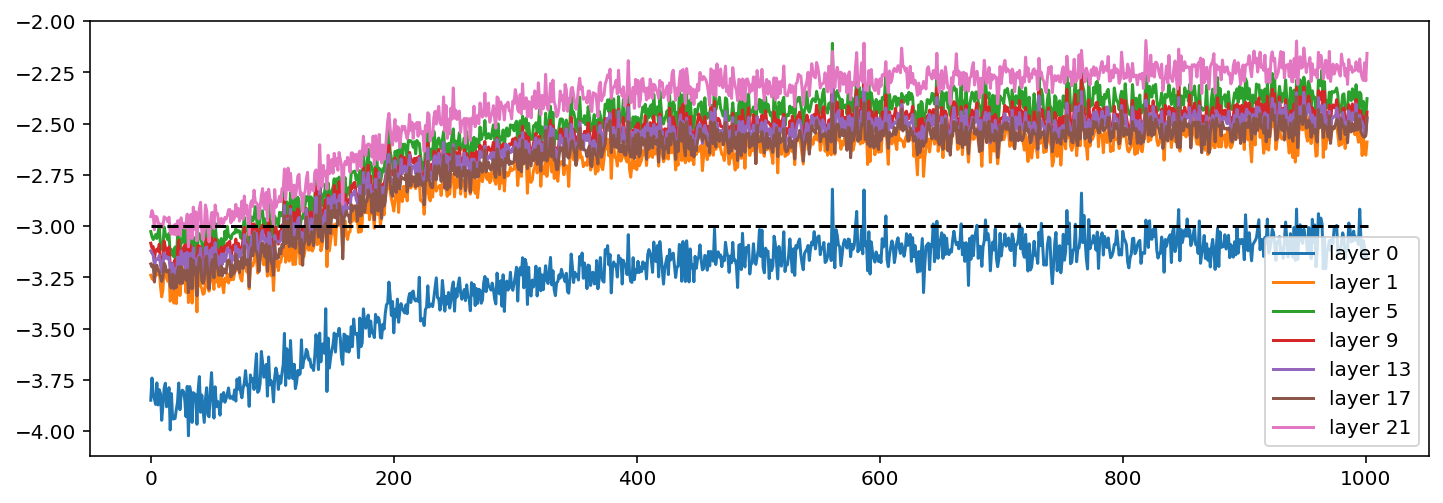

In [162]:
plt.figure(figsize=(12, 4))
legends = []
for i, p in enumerate(params):
    if p.ndim == 2:
        plt.plot([update_ratio_history[j][i] for j in range(len(update_ratio_history))])
        legends.append(f'layer {i}')
plt.plot([0, len(update_ratio_history)], [-3, -3], 'k--')
plt.legend(legends)